
Contents
- importing df_en_10K.pkl
- splitting it into training and test set
- tokenization and vectorization
- SVM classification
	- SVM with tokenized lyrics - no optimization
	- SVM with tokenized lyrics - with parameter optimization
- Naive Bayes
- Decision Tree
- Random Forest
- LSTM
- CNN
- LSTM with FT
- CNN with FT
- LSTM with W2V
- CNN with W2V

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import spacy
import re
spacy.cli.download('en_core_web_sm')
nlp = spacy.load('en_core_web_sm')
import  nltk
print(nltk.__version__)

import pickle

#from december 1st 2022, you might need to change sklearn into scikit-learn
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
3.7


In [3]:
import keras.utils
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input
from keras.layers import Conv1D, GlobalMaxPooling1D, GlobalMaxPool1D
from keras.layers import LSTM
from keras.utils import pad_sequences
from keras.layers import Dense, Embedding
from keras.layers import SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD

In [4]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras import Model
from keras.utils import to_categorical
from keras.utils import pad_sequences 


#Importing the english songs dataset

In [5]:
with open ('/content/drive/MyDrive/Progetto_TA_2022/pickled_df/df_en_10K.pkl', mode='br') as inputfile:
  df_en = pickle.load(inputfile)

In [6]:
df_en = df_en.reset_index()
df_en = df_en.drop(['index'], axis = 1)

In [7]:
df_en

,Artist,Song,Genre,Language,Lyrics
0,switchfoot,awakening,Rock,en,face down with the la curbside endings and the...
1,the supremes,get ready,Pop,en,i never met a boy who makes me feel the way th...
2,the twilight sad,half a person,Rock,en,call me morbid call me pale i ve spent six yea...
3,bill monroe,wayfaring stranger,Country,en,i am a poor wayfaring stranger traveling throu...
4,erasure,boy,Pop,en,love you boy till i fall the child in me again...
...,...,...,...,...,...
9995,carcass,forensic clinicism the sanguine article,Metal,en,salutiferous exaltation through fusty spatteri...
9996,felix da housecat,ready 2 wear,Electronic,en,you are a star you wear it well you blow my mi...
9997,donna summer,there goes my baby,Pop,en,all alone i sit looking out of the window and ...
9998,elton john,all across the havens,Rock,en,music by elton john lyrics by bernie taupin re...


#Splitting the dataset in training set and test set

In [8]:
import sklearn
from sklearn.model_selection import train_test_split

In [9]:
en_train, en_test = sklearn.model_selection.train_test_split(df_en, test_size=0.20, train_size=0.80)

In [10]:
en_train.shape, en_test.shape

((8000, 5), (2000, 5))

In [11]:
df_en['Genre'].value_counts() 

Rock          4318
Pop           3479
Metal          766
Jazz           453
Folk           341
Indie          292
R&B            106
Country         85
Electronic      81
Hip-Hop         79
Name: Genre, dtype: int64

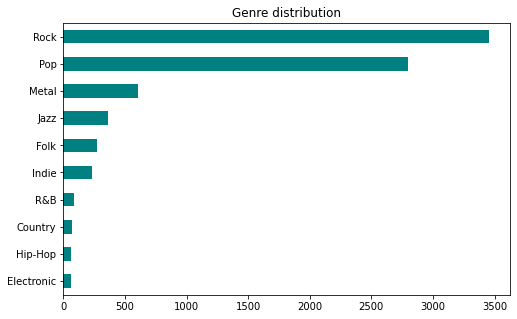

In [12]:
plt.rcParams['figure.figsize'] = [8,5]
x = en_train['Genre'].value_counts().sort_values(ascending = True)
plt.title("Genre distribution")
x.plot(kind ='barh', color="teal")

#Tokenizing the lyrics with spacy

In [13]:
x_train = en_train['Lyrics'].tolist()
y_train = en_train['Genre'].tolist()

In [14]:
x_test = en_test['Lyrics'].tolist()
y_test = en_test['Genre'].tolist()

In [15]:
set(y_train)

{'Country',
 'Electronic',
 'Folk',
 'Hip-Hop',
 'Indie',
 'Jazz',
 'Metal',
 'Pop',
 'R&B',
 'Rock'}

In [16]:
sample_idx = 1345
x_train[sample_idx]

'the night is young the skies are clear so if you want to go walking dear it s delightful it s delicious it s de lovely i understand the reason why you re sentimental cause so am i it s delightful it s delicious it s de lovely you can tell at a glance what a swell night this is for romance you can hear dear mother nature murmuring low let yourself go so please be sweet my chickadee and when i kiss you just say to me it s delightful it s delicious it s delectable it s delirious it s dilemma it s delimit it s deluxe it s de lovely i feel a sudden urge to sing the kind of ditty that invokes the spring i ll control my desire to curse while you crucify the verse this verse i started seems to me the tin pantithesis of a melody so spare us all the pain just skip the darn thing and sing the refrain mi mi mi mi re re re re do sol mi do la si the night is young the skies are clear so if you want to go walking dear it s delightful it s delicious it s de lovely i understand the reason why you re s

In [17]:
y_train[sample_idx]

'Pop'

In [18]:
import string
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from nltk import word_tokenize, pos_tag

stopword_list = stopwords.words('english')
punctuations = string.punctuation

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [19]:
def spacy_tokenizer (text):
    
    doc = nlp(text)

    #lemmatizing tokens and lowering case
    lemmas = [token.lemma_.lower() for token in doc]

    #removing stopwords and punctuations
    lemmas_stop= [token for token in lemmas if token not in stopword_list and token not in punctuations]  

    lemma_bigrams = ['BI_'+p1+'_'+p2 for p1,p2 in nltk.ngrams(lemmas_stop,2)]
    lemma_trigrams = ['TRI_'+p1+'_'+p2+'_'+p3 for p1,p2,p3 in nltk.ngrams(lemmas_stop,3)] 
    
    all_tokens = list()
    all_tokens.extend(lemmas_stop)
    all_tokens.extend(lemma_bigrams)
    all_tokens.extend(lemma_trigrams)
    return all_tokens

#Token vectorization with CountVectorizer and spacy_tokenizer function above

In [20]:
vectors = CountVectorizer (analyzer = spacy_tokenizer, min_df = 10)

In [21]:
print ('fit')
vectors.fit(x_train)
print('transform')
x_train_tok = vectors.transform(x_train)
x_test_tok = vectors.transform(x_test)
print ('done')

fit
transform
done


In [22]:
with open('/content/drive/MyDrive/Progetto_TA_2022/tokenized_df/en_x_train_tok.pkl', 'wb') as outfile:
  pickle.dump(x_train_tok, outfile)
with open('/content/drive/MyDrive/Progetto_TA_2022/tokenized_df/en_x_test_tok.pkl', 'wb') as outfile:
  pickle.dump(x_test_tok, outfile)

In [23]:
with open('/content/drive/MyDrive/Progetto_TA_2022/tokenized_df/en_x_train_tok.pkl', mode = 'br') as infile:
  x_train_tok = pickle.load(infile)
with open('/content/drive/MyDrive/Progetto_TA_2022/tokenized_df/en_x_test_tok.pkl', mode = 'br') as infile:
  x_test_tok = pickle.load(infile)

In [24]:
len(vectors.vocabulary_)

10794

In [25]:
vectors.vocabulary_

{'crowd': 7529,
 'wait': 10600,
 'hero': 8392,
 'sea': 9775,
 'great': 8277,
 'toast': 10396,
 'freedom': 8124,
 'everyone': 7905,
 'talk': 10275,
 'fear': 7987,
 'cannon': 7220,
 'roar': 9652,
 'send': 9800,
 'thousand': 10354,
 'soul': 10028,
 'ocean': 9139,
 'floor': 8065,
 'victory': 10572,
 'simple': 9904,
 'plan': 9334,
 'put': 9487,
 'place': 9331,
 'common': 7405,
 'man': 8852,
 'set': 9815,
 'sail': 9723,
 'southern': 10035,
 'star': 10094,
 'haul': 8352,
 'away': 6915,
 'restless': 9608,
 'say': 9748,
 '’s': 10790,
 'bang': 6951,
 'uniform': 10518,
 'control': 7457,
 'get': 8202,
 'take': 10270,
 'pot': 9397,
 'gold': 8243,
 'ever': 7899,
 'fearless': 7988,
 'universe': 10523,
 'hold': 8418,
 'nation': 9055,
 'together': 10400,
 'teach': 10293,
 'word': 10730,
 'young': 10775,
 'old': 9155,
 'forever': 8097,
 'cut': 7560,
 'anchor': 6835,
 'today': 10398,
 'storm': 10138,
 'deep': 7627,
 'water': 10628,
 'lie': 8741,
 'warm': 10618,
 'wind': 10697,
 'sky': 9939,
 'never': 908

# SVM Classification

---



---



Classification report:
              precision    recall  f1-score   support

     Country       0.00      0.00      0.00        16
  Electronic       0.00      0.00      0.00        17
        Folk       0.14      0.03      0.05        68
     Hip-Hop       0.00      0.00      0.00        15
       Indie       0.14      0.02      0.03        62
        Jazz       0.49      0.19      0.27        95
       Metal       0.44      0.24      0.31       157
         Pop       0.54      0.62      0.57       683
         R&B       0.00      0.00      0.00        21
        Rock       0.55      0.68      0.61       866

    accuracy                           0.53      2000
   macro avg       0.23      0.18      0.18      2000
weighted avg       0.49      0.53      0.50      2000

Confusion matrix:
[[  0   0   0   0   0   0   1   3   0  12]
 [  0   0   0   0   0   0   2   8   0   7]
 [  0   0   2   0   0   0   1  20   0  45]
 [  0   0   0   0   0   0   0  12   0   3]
 [  0   0   1   0   1   0   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


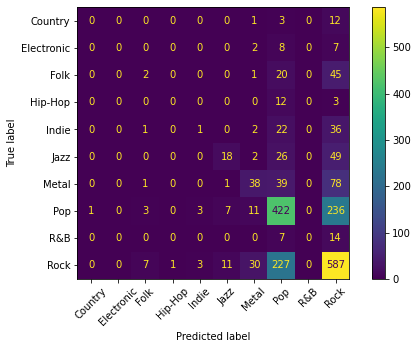

In [26]:
svm_pipeline = Pipeline([
    ('vect', CountVectorizer(min_df = 5)), #tokenization
    ('sel', SelectKBest(chi2, k=3000)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

svm_pipeline.fit(x_train,y_train)
predictions = svm_pipeline.predict(x_test)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

ConfusionMatrixDisplay.from_estimator(svm_pipeline, x_test, y_test)  
plt.xticks(rotation=45)
plt.show()

SVM classification with tokenized lyrics - no optimization

---




In [27]:
svm_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k=3000)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

svm_pipeline.fit(x_train_tok,y_train)
predictions = svm_pipeline.predict(x_test_tok)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)


Classification report:
              precision    recall  f1-score   support

     Country       0.00      0.00      0.00        16
  Electronic       0.00      0.00      0.00        17
        Folk       0.05      0.01      0.02        68
     Hip-Hop       0.00      0.00      0.00        15
       Indie       0.27      0.05      0.08        62
        Jazz       0.55      0.19      0.28        95
       Metal       0.46      0.28      0.35       157
         Pop       0.55      0.62      0.58       683
         R&B       0.00      0.00      0.00        21
        Rock       0.56      0.69      0.62       866

    accuracy                           0.54      2000
   macro avg       0.24      0.18      0.19      2000
weighted avg       0.50      0.54      0.51      2000

Confusion matrix:
[[  0   0   1   0   0   0   1   3   0  11]
 [  0   0   0   0   0   0   0   6   0  11]
 [  0   0   1   0   0   1   3  18   0  45]
 [  0   0   0   0   0   0   1  11   0   3]
 [  0   0   0   0   3   0   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM classification with tokenized lyrics - with  optimization of parameters

---



GridSearch application:

In [28]:
opt_pipeline = Pipeline([
    ('sel', SelectKBest(chi2)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', LinearSVC())  # learning algorithm
])

param_grid = [{'sel__k': [1000, 2000, 3000,'all'], 'learner__C': [0.01, 0.1, 1, 10, 100]}]
SVM_opt_search = GridSearchCV(opt_pipeline, param_grid, cv=None, n_jobs = 3, verbose=True).fit(x_train_tok,y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [29]:
SVM_opt_search.best_params_

{'learner__C': 0.1, 'sel__k': 'all'}

In [30]:
SVM_opt_search.best_estimator_

Pipeline(steps=[('sel',
                 SelectKBest(k='all',
                             score_func=<function chi2 at 0x7fc410a30e60>)),
                ('tfidf', TfidfTransformer()), ('learner', LinearSVC(C=0.1))])

In [31]:
opt_predictions = SVM_opt_search.best_estimator_.predict(x_test_tok)

print('Classification report:')
print(classification_report(y_test, opt_predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, opt_predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

     Country       0.00      0.00      0.00        16
  Electronic       0.00      0.00      0.00        17
        Folk       0.00      0.00      0.00        68
     Hip-Hop       0.00      0.00      0.00        15
       Indie       0.00      0.00      0.00        62
        Jazz       0.83      0.05      0.10        95
       Metal       0.52      0.10      0.17       157
         Pop       0.59      0.57      0.58       683
         R&B       0.00      0.00      0.00        21
        Rock       0.53      0.79      0.63       866

    accuracy                           0.55      2000
   macro avg       0.25      0.15      0.15      2000
weighted avg       0.51      0.55      0.49      2000

Confusion matrix:
[[  0   0   0   0   0   0   1   3   0  12]
 [  0   0   0   0   0   0   1   4   0  12]
 [  0   0   0   0   0   0   0   8   0  60]
 [  0   0   0   0   0   0   0  12   0   3]
 [  0   0   0   0   0   0   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Features that weight more on classification:

In [32]:
tokenizer = vectors
selector = svm_pipeline.named_steps['sel']
classifier = svm_pipeline.named_steps['learner']

In [33]:
feature_names = tokenizer.get_feature_names_out()
feats_w_score = list()
for index,(selected,score) in enumerate(zip(selector.get_support(),selector.scores_)):
    feats_w_score.append((score,selected,feature_names[index]))
feats_w_score = sorted(feats_w_score)
len(feats_w_score)

10794

In [34]:
feats_w_score[:100],feats_w_score[-100:]

([(1.6448514233963314, False, 'BI_need_much'),
  (1.6545245960291908, False, 'BI_ever_learn'),
  (1.6686441312590676, False, 'shark'),
  (1.6853401841237303, False, 'BI_give_answer'),
  (1.6853401841237303, False, 'BI_guess_see'),
  (1.6853401841237303, False, 'BI_leave_fall'),
  (1.6853401841237303, False, 'BI_world_cause'),
  (1.6853401841237303, False, 'extend'),
  (1.6853401841237303, False, 'ransom'),
  (1.7459036264745407, False, 'BI_put_test'),
  (1.8029538408158508, False, 'BI_know_happen'),
  (1.8029538408158508, False, 'BI_right_beside'),
  (1.8029538408158508, False, 'TRI_yeah_yeah_go'),
  (1.8029538408158508, False, 'property'),
  (1.8342296628163506, False, 'BI_hard_understand'),
  (1.8764115800717343, False, 'kindness'),
  (1.9171158253030682, False, 'BI_break_cry'),
  (1.925422759947942, False, 'BI_blue_oh'),
  (1.9405336341501935, False, 'BI_beauty_queen'),
  (1.9405336341501935, False, 'BI_cause_everybody'),
  (1.9405336341501935, False, 'BI_mind_way'),
  (1.9405336341

In [35]:
feats_w_classifier_weight = list()
for index,weight in enumerate(selector.inverse_transform(classifier.coef_)[0]):
    if weight!=0:
        feats_w_classifier_weight.append((weight,feature_names[index]))
feats_w_classifier_weight = sorted(feats_w_classifier_weight)
len(feats_w_classifier_weight)

2831

In [36]:
feats_w_classifier_weight[-100:]

[(0.4998222192019607, 'old'),
 (0.5001947552404783, 'et'),
 (0.5008587274742706, 'BI_dance_night'),
 (0.5022912289862626, 'single'),
 (0.5067217555416972, 'linger'),
 (0.5083568620683061, 'lord'),
 (0.5111082436594515, 'BI_go_bad'),
 (0.5117173990314282, 'BI_away_go'),
 (0.5184888102754546, 'BI_know_good'),
 (0.5190173390297825, 'memory'),
 (0.5190230595244543, 'g'),
 (0.5238038971569143, 'foolish'),
 (0.5360680546642104, 'BI_know_get'),
 (0.542784135976372, 'BI_well_man'),
 (0.5433041042772523, 'BI_bad_go'),
 (0.5442850670810833, 'BI_really_need'),
 (0.5463791084248903, 'BI_alone_think'),
 (0.546455939310852, 'rose'),
 (0.547837248744404, 'BI_love_heart'),
 (0.5485541240386075, 'ole'),
 (0.5493708338853418, 'BI_since_go'),
 (0.5507396199702905, 'BI_get_ring'),
 (0.5550960538999857, 'BI_heart_let'),
 (0.5579592526525341, 'fiddle'),
 (0.5596281733346263, 'BI_never_make'),
 (0.5609089705598683, 'BI_go_tell'),
 (0.5646371539330864, 'BI_close_eye'),
 (0.5648579978719741, 'BI_come_oh'),
 (0

In [37]:
feats_w_classifier_weight[:100]


[(-0.6893837340662259, 'baby'),
 (-0.6415280834832996, 'away'),
 (-0.6000487633552066, 'side'),
 (-0.5887946379566933, 'speak'),
 (-0.5806985187209528, 'people'),
 (-0.5383301898812599, 'inside'),
 (-0.507995136088194, 'come'),
 (-0.4800936982993607, 'time'),
 (-0.468832505656694, 'til'),
 (-0.45037460768756205, 'fear'),
 (-0.4428511771139779, 'crazy'),
 (-0.43342178655123714, 'break'),
 (-0.43263735315643853, 'give'),
 (-0.4203168233461662, 'win'),
 (-0.4174313438752827, 'play'),
 (-0.3927913226185427, 'toy'),
 (-0.39184285265328045, 'meet'),
 (-0.389703798417341, 'lovely'),
 (-0.3864240678511682, 'stop'),
 (-0.3776595295519972, 'soul'),
 (-0.37730368336532977, 'summer'),
 (-0.3659530947419495, 'save'),
 (-0.36522140246595763, 'sky'),
 (-0.35685760455570537, 'four'),
 (-0.3475562755535405, 'alright'),
 (-0.34753471863432295, 'live'),
 (-0.34712164345735713, 'BI_know_know'),
 (-0.34457399465356164, 'repeat'),
 (-0.3413499530605286, 'way'),
 (-0.33631609558298087, 'lonesome'),
 (-0.3357

#Naïve Bayes Classification

---



In [38]:
NBC_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k=3000)),  # feature selection
    ('learner', MultinomialNB())  # learning algorithm
])

NBC_pipeline.fit(x_train_tok,y_train)
predictions = NBC_pipeline.predict(x_test_tok)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

     Country       0.00      0.00      0.00        16
  Electronic       0.00      0.00      0.00        17
        Folk       0.14      0.22      0.17        68
     Hip-Hop       0.09      0.53      0.15        15
       Indie       0.04      0.03      0.04        62
        Jazz       0.31      0.41      0.35        95
       Metal       0.31      0.58      0.40       157
         Pop       0.60      0.33      0.42       683
         R&B       0.00      0.00      0.00        21
        Rock       0.54      0.56      0.55       866

    accuracy                           0.43      2000
   macro avg       0.20      0.27      0.21      2000
weighted avg       0.48      0.43      0.44      2000

Confusion matrix:
[[  0   0   2   0   0   3   2   0   0   9]
 [  0   0   1   0   2   1   2   5   0   6]
 [  0   0  15   0   0   3   9   2   0  39]
 [  0   0   0   8   0   0   0   5   0   2]
 [  0   1   3   0   2   1  1

#Decision Tree Classification 

---



In [39]:
dt_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k=3000)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', DecisionTreeClassifier())  # learning algorithm
])

dt_pipeline.fit(x_train_tok,y_train)
predictions = dt_pipeline.predict(x_test_tok)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

     Country       0.00      0.00      0.00        16
  Electronic       0.00      0.00      0.00        17
        Folk       0.05      0.04      0.05        68
     Hip-Hop       0.25      0.20      0.22        15
       Indie       0.07      0.05      0.06        62
        Jazz       0.18      0.17      0.17        95
       Metal       0.24      0.22      0.23       157
         Pop       0.46      0.45      0.46       683
         R&B       0.06      0.05      0.05        21
        Rock       0.50      0.54      0.52       866

    accuracy                           0.42      2000
   macro avg       0.18      0.17      0.18      2000
weighted avg       0.41      0.42      0.41      2000

Confusion matrix:
[[  0   0   0   0   0   1   2   3   0  10]
 [  0   0   0   0   1   1   2   5   0   8]
 [  1   0   3   0   2   5   4  17   0  36]
 [  0   0   0   3   1   0   0   9   0   2]
 [  0   0   1   0   3   3   

# Random Forest Classification

---

In [40]:
RF_pipeline = Pipeline([
    ('sel', SelectKBest(chi2, k=3000)),  # feature selection
    ('tfidf', TfidfTransformer()),  # weighting
    ('learner', RandomForestClassifier())  # learning algorithm
])

RF_pipeline.fit(x_train_tok,y_train)
predictions = RF_pipeline.predict(x_test_tok)

print('Classification report:')
print(classification_report(y_test, predictions))
print('Confusion matrix:')
cm = confusion_matrix(y_test, predictions)
print(cm)

Classification report:
              precision    recall  f1-score   support

     Country       0.00      0.00      0.00        16
  Electronic       0.00      0.00      0.00        17
        Folk       0.00      0.00      0.00        68
     Hip-Hop       0.00      0.00      0.00        15
       Indie       0.67      0.03      0.06        62
        Jazz       0.57      0.14      0.22        95
       Metal       0.78      0.04      0.08       157
         Pop       0.68      0.49      0.57       683
         R&B       0.00      0.00      0.00        21
        Rock       0.52      0.89      0.66       866

    accuracy                           0.56      2000
   macro avg       0.32      0.16      0.16      2000
weighted avg       0.57      0.56      0.50      2000

Confusion matrix:
[[  0   0   0   0   0   0   0   3   0  13]
 [  0   0   0   0   0   0   0   2   0  15]
 [  0   0   0   0   0   0   0   3   0  65]
 [  0   0   0   0   0   0   0  13   0   2]
 [  0   0   0   0   2   0   

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#LSTM Classification

---



In [41]:
en_train['Genre_number'] = en_train['Genre'] #converting the strings into int in the Genre column

numbers = []
for i in en_train['Genre']:
  if i == 'Rock':
    numbers.append(0)
  
  if i == 'Pop':
    numbers.append(1)
   
  if i == 'Metal':
    numbers.append(2)
    
  if i == 'Jazz':
    numbers.append(3)

  if i == 'Folk':
   numbers.append(4)
  
  if i == 'Indie':
   numbers.append(5)

  if i == 'R&B':
    numbers.append(6)
  
  if i == 'Hip-Hop':
    numbers.append(7)
  
  if i == 'Electronic':
    numbers.append(8)
  
  elif i == 'Country':
    numbers.append(9)

In [42]:
en_train['Genre_number'] = numbers

In [43]:
en_test['Genre_number'] = en_test['Genre']

numbers_test = []
for i in en_test['Genre']:
  if i == 'Rock':
    numbers_test.append(0)
  
  if i == 'Pop':
    numbers_test.append(1)
   
  if i == 'Metal':
    numbers_test.append(2)
    
  if i == 'Jazz':
    numbers_test.append(3)

  if i == 'Folk':
   numbers_test.append(4)
  
  if i == 'Indie':
   numbers_test.append(5)

  if i == 'R&B':
    numbers_test.append(6)
  
  if i == 'Hip-Hop':
    numbers_test.append(7)
  
  if i == 'Electronic':
    numbers_test.append(8)
  
  elif i == 'Country':
    numbers_test.append(9)


In [44]:
en_test['Genre_number'] = numbers_test

In [45]:
en_test.sample(5)

,Artist,Song,Genre,Language,Lyrics,Genre_number
8974,"james, etta",welcome to the jungle,Jazz,en,welcome to the jungle we ve got fun n games we...,3
9749,the monkees,what am i doing hangin' round,Rock,en,just a loud mouth yankee i went down to mexico...,0
8060,new model army,my country,Rock,en,tell all the people who believe what they read...,0
8793,the conells,74 75,Rock,en,got no reason for coming to me in the rain run...,0
6671,tom t. hall,sneaky snake,Folk,en,boys and girls take warning if you go near the...,4


In [46]:
y_train = en_train['Genre_number'] #substituting the columns in the variables
y_test = en_test['Genre_number']

In [47]:
y_train = to_categorical(y_train,10) #converting to one-hot vectors
y_test = to_categorical(y_test, 10)

In [48]:
y_train.shape, y_test.shape

((8000, 10), (2000, 10))

In [49]:
#max number of words to be used
max_features = 20000
#max number of words in each lyrics
maxlen = 200
#fixed size
embed_size = 128

batch_size = 64
epochs = 10

tokenizer = Tokenizer(num_words=max_features, lower=True)
tokenizer.fit_on_texts(list(x_train))
list_tokenized_train = tokenizer.texts_to_sequences(x_train)
list_tokenized_test = tokenizer.texts_to_sequences(x_test)

X_train_final = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test_final = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [50]:
X_train_final.shape, y_train.shape

((8000, 200), (8000, 10))

In [51]:
X_test_final.shape, y_test.shape

((2000, 200), (2000, 10))

In [52]:
model = Sequential()
model.add(Embedding(max_features, embed_size))
model.add(LSTM(20, dropout=0.4, recurrent_dropout=0.4))
model.add(Dropout(0.4))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.8), metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2560000   
                                                                 
 lstm (LSTM)                 (None, 20)                11920     
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 32)                672       
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 2,572,922
Trainable params: 2,572,922
Non-

In [53]:
lstm = model.fit(X_train_final, y_train,
                 batch_size=batch_size, 
                 epochs=epochs, 
                 shuffle = True, 
                 validation_split=0.2, 
                 callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/10
100/100 [==============================] - 50s 461ms/step - loss: 1.7365 - accuracy: 0.4233 - val_loss: 1.5160 - val_accuracy: 0.4206
Epoch 2/10
100/100 [==============================] - 35s 355ms/step - loss: 1.4948 - accuracy: 0.4205 - val_loss: 1.4928 - val_accuracy: 0.4206
Epoch 3/10
100/100 [==============================] - 37s 370ms/step - loss: 1.4754 - accuracy: 0.4247 - val_loss: 1.4877 - val_accuracy: 0.4206
Epoch 4/10
100/100 [==============================] - 37s 373ms/step - loss: 1.4674 - accuracy: 0.4300 - val_loss: 1.4849 - val_accuracy: 0.4206
Epoch 5/10
100/100 [==============================] - 36s 357ms/step - loss: 1.4612 - accuracy: 0.4300 - val_loss: 1.4836 - val_accuracy: 0.4206
Epoch 6/10
100/100 [==============================] - 36s 365ms/step - loss: 1.4569 - accuracy: 0.4264 - val_loss: 1.4853 - val_accuracy: 0.4206
Epoch 7/10
100/100 [==============================] - 35s 355ms/step - loss: 1.4544 - accuracy: 0.4325 - val_loss: 1.4834 - val_ac

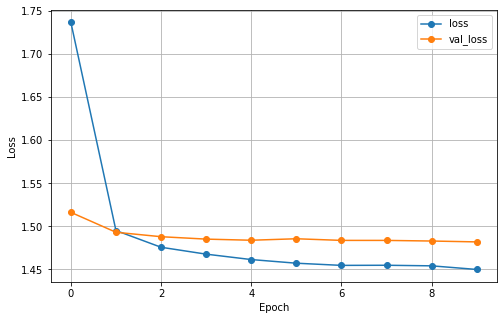

In [54]:
plt.plot(lstm.history['loss'], label='loss', marker = 'o')
plt.plot(lstm.history['val_loss'], label = 'val_loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='upper right')

Testing LSTM Classification


In [55]:
lstm_pred= np.round(model.predict(X_test_final))

63/63 [==============================] - 4s 53ms/step


In [56]:
print('Accuracy %s' % accuracy_score(y_test, lstm_pred))
print('F1-score %s' % f1_score(y_test, lstm_pred, average=None))
print('Classification report:')
print(classification_report(y_test, lstm_pred))

Accuracy 0.0
F1-score [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       866
           1       0.00      0.00      0.00       683
           2       0.00      0.00      0.00       157
           3       0.00      0.00      0.00        95
           4       0.00      0.00      0.00        68
           5       0.00      0.00      0.00        62
           6       0.00      0.00      0.00        21
           7       0.00      0.00      0.00        15
           8       0.00      0.00      0.00        17
           9       0.00      0.00      0.00        16

   micro avg       0.00      0.00      0.00      2000
   macro avg       0.00      0.00      0.00      2000
weighted avg       0.00      0.00      0.00      2000
 samples avg       0.00      0.00      0.00      2000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#CNN Classification

In [57]:
#max number of words to be used
max_features = 20000
#max number of words in each lyrics
maxlen = 200
#fixed size
embed_size = 128

batch_size = 64
epochs = 20
filters = 10
kernel_size = 3
hidden_dims = 10

tokenizer = Tokenizer(num_words=max_features, lower=True)
tokenizer.fit_on_texts(list(x_train))
list_tokenized_train = tokenizer.texts_to_sequences(x_train)
list_tokenized_test = tokenizer.texts_to_sequences(x_test)

X_train_final = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test_final = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [58]:
X_train_final[0]

array([    0,     0,     0,     0,     0,     0,     0,     0,  3492,
         138,   262,    16,     3, 12176,    22,   234,  1823,    14,
           3,   484,    69,     3,  1067,    14,     3,   484,     6,
        2801,     5,   834,    22,   442,    71,  2240,    14,   466,
           4,     3,  8550,  2851,  1398,     6,   735,  1155,     5,
           3,   864,   457,  2697,    59,     6,  1064,   996,   150,
          12,   200,    99,    36,  2012,   102,   420,  1344,    22,
           3,  1836,   440,   420,  1344,    22,     3,  1836,   440,
        4095,    85,     2,  1520,  1155,   420,  1344,    22,     3,
        1836,   440,    71,   548,    13,    71,  2698,  1344,    36,
          95,  5038,  3772,    33,   141,  5800,    29,    71,   717,
         505,   141,   232,  5038,    42,     5,    74,    13,  2437,
          14,   528,   420,  1344,    22,     3,  1836,   440,   420,
        1344,    22,     3,  1836,   440,  4095,    85,     2,  1520,
        1155,   420,

In [59]:
model = Sequential()

model.add(Embedding(max_features, embed_size))
model.add(Dropout(0.4))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())

#vanilla dense layer
model.add(Dense(hidden_dims))
model.add(Dropout(0.4))
model.add(Activation('relu'))

#output layer
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         2560000   
                                                                 
 dropout_2 (Dropout)         (None, None, 128)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 10)          3850      
                                                                 
 global_max_pooling1d (Globa  (None, 10)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dropout_3 (Dropout)         (None, 10)                0         
                                                      

In [60]:
cnn= model.fit(X_train_final, y_train, 
          batch_size = batch_size, 
          epochs=epochs, 
          shuffle=True, 
          validation_split=0.1,
          callbacks= [EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/20
113/113 [==============================] - 6s 11ms/step - loss: 1.9247 - accuracy: 0.3467 - val_loss: 1.6023 - val_accuracy: 0.4288
Epoch 2/20
113/113 [==============================] - 1s 6ms/step - loss: 1.6119 - accuracy: 0.4100 - val_loss: 1.5133 - val_accuracy: 0.4525
Epoch 3/20
113/113 [==============================] - 1s 6ms/step - loss: 1.5257 - accuracy: 0.4365 - val_loss: 1.4872 - val_accuracy: 0.4750
Epoch 4/20
113/113 [==============================] - 1s 6ms/step - loss: 1.4577 - accuracy: 0.4800 - val_loss: 1.4635 - val_accuracy: 0.4812
Epoch 5/20
113/113 [==============================] - 1s 6ms/step - loss: 1.3775 - accuracy: 0.5171 - val_loss: 1.4556 - val_accuracy: 0.4900
Epoch 6/20
113/113 [==============================] - 1s 6ms/step - loss: 1.3166 - accuracy: 0.5475 - val_loss: 1.4464 - val_accuracy: 0.5100
Epoch 7/20
113/113 [==============================] - 1s 6ms/step - loss: 1.2486 - accuracy: 0.5731 - val_loss: 1.4516 - val_accuracy: 0.5200
Epoch

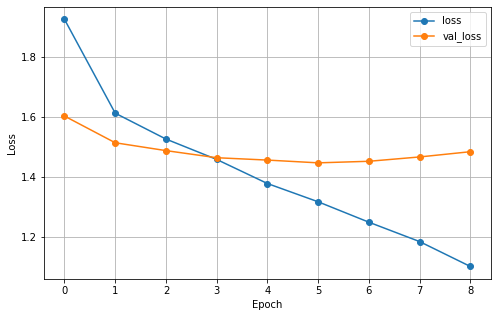

In [61]:
plt.plot(cnn.history['loss'], label='loss', marker = 'o')
plt.plot(cnn.history['val_loss'], label = 'val_loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='upper right')

Testing CNN Classification

In [62]:
cnn_pred= np.round(model.predict(X_test_final))

63/63 [==============================] - 0s 3ms/step


In [63]:
print('Accuracy %s' % accuracy_score(y_test, cnn_pred))
print('F1-score %s' % f1_score(y_test, cnn_pred, average=None))
print('Classification report:')
print(classification_report(y_test, cnn_pred, zero_division=1))

Accuracy 0.3385
F1-score [0.49226804 0.51215278 0.         0.         0.         0.
 0.         0.         0.         0.        ]
Classification report:
              precision    recall  f1-score   support

           0       0.56      0.44      0.49       866
           1       0.63      0.43      0.51       683
           2       1.00      0.00      0.00       157
           3       1.00      0.00      0.00        95
           4       1.00      0.00      0.00        68
           5       1.00      0.00      0.00        62
           6       1.00      0.00      0.00        21
           7       1.00      0.00      0.00        15
           8       1.00      0.00      0.00        17
           9       1.00      0.00      0.00        16

   micro avg       0.59      0.34      0.43      2000
   macro avg       0.92      0.09      0.10      2000
weighted avg       0.68      0.34      0.39      2000
 samples avg       0.76      0.34      0.34      2000



#Classification with FastText

Preparing the embeddings

In [64]:
import codecs
#load embeddings
print('loading word embeddings...')
#dictionary where the keys will be words and the values will be coefficients 
embeddings_index = {}
f = codecs.open('../content/drive/MyDrive/Progetto_TA_2022/embeddings/crawl-300d-2M.vec', encoding='utf-8')
for line in f:
    #values returns a list where the first element is a word and the others are the vector coefficients for that word
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

loading word embeddings...
found 1999996 word vectors


In [65]:
maxlen= 200
embed_size = 300 #standard length for FastTest
X_train_final = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test_final = pad_sequences (list_tokenized_test, maxlen=maxlen)

In [66]:
max_features = 20000
tokenizer = Tokenizer (num_words = max_features)
tokenizer.fit_on_texts(list(x_train))
list_tokenized_train = tokenizer.texts_to_sequences(x_train)
list_tokenized_test = tokenizer.texts_to_sequences(x_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

dictionary size:  32902


In [67]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(max_features, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_size))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 1206


In [68]:
word_index

{'i': 1,
 'you': 2,
 'the': 3,
 'and': 4,
 'to': 5,
 'a': 6,
 'it': 7,
 'me': 8,
 's': 9,
 't': 10,
 'my': 11,
 'in': 12,
 'that': 13,
 'of': 14,
 'your': 15,
 'on': 16,
 'we': 17,
 'm': 18,
 'all': 19,
 'be': 20,
 'can': 21,
 'for': 22,
 'is': 23,
 'love': 24,
 'don': 25,
 'so': 26,
 'know': 27,
 'like': 28,
 'but': 29,
 'with': 30,
 'just': 31,
 'what': 32,
 'up': 33,
 'this': 34,
 're': 35,
 'no': 36,
 'when': 37,
 'oh': 38,
 'do': 39,
 'll': 40,
 'get': 41,
 'got': 42,
 'now': 43,
 'she': 44,
 'out': 45,
 'if': 46,
 'go': 47,
 'they': 48,
 'there': 49,
 'one': 50,
 'down': 51,
 'time': 52,
 'baby': 53,
 'yeah': 54,
 'never': 55,
 'are': 56,
 'see': 57,
 'let': 58,
 'was': 59,
 've': 60,
 'want': 61,
 'not': 62,
 'come': 63,
 'will': 64,
 'have': 65,
 'make': 66,
 'say': 67,
 'way': 68,
 'from': 69,
 'cause': 70,
 'he': 71,
 'back': 72,
 'at': 73,
 'take': 74,
 'how': 75,
 'her': 76,
 'as': 77,
 'gonna': 78,
 'here': 79,
 'life': 80,
 'feel': 81,
 'need': 82,
 'heart': 83,
 'wanna':

In [69]:
words_not_found[:50]

['i’m',
 'i’ll',
 'ain’t',
 'i’ve',
 '‘cause',
 'won’t',
 'skrr',
 'she’s',
 'we’re',
 'rudebox',
 'there’s',
 'lovin’',
 'iâ€™m',
 'i´m',
 'let’s',
 'husslin',
 'footstompin',
 'weepin',
 'it´s',
 'loola',
 'soulville',
 'rybody',
 'couldn’t',
 'tweedily',
 'shuop',
 'i’d',
 '‘em',
 'you´ve',
 'blakpeople',
 'nickee',
 'one…',
 'teasable',
 'hunned',
 'videotheque',
 'kuniva',
 'don´t',
 'you’ll',
 'i’ma',
 'you’ve',
 '‘till',
 'ruinin',
 'x—',
 'jazze',
 'ooowwwhooaa',
 'illygirl',
 'skokiaan',
 'eyyy',
 'parara',
 'aimais',
 'ooooooooooooooo']

# LSTM Training with FastText

In [70]:
model = Sequential()
model.add(Embedding(nb_words, embed_size, weights = [embedding_matrix], trainable = False))
model.add(LSTM(20, return_sequences=True))
model.add(Dropout(0.4))
model.add(GlobalMaxPool1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.8), metrics=['accuracy'])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 300)         6000000   
                                                                 
 lstm_1 (LSTM)               (None, None, 20)          25680     
                                                                 
 dropout_4 (Dropout)         (None, None, 20)          0         
                                                                 
 global_max_pooling1d_1 (Glo  (None, 20)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 64)                1344      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                      

In [71]:
lstm_FT = model.fit(X_train_final, y_train,
                 batch_size=batch_size, 
                 epochs=10, 
                 shuffle = True, 
                 validation_split=0.2,
                 callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

lstm_FT

Epoch 1/10
100/100 [==============================] - 4s 15ms/step - loss: 1.5917 - accuracy: 0.3914 - val_loss: 1.5295 - val_accuracy: 0.4206
Epoch 2/10
100/100 [==============================] - 1s 9ms/step - loss: 1.4678 - accuracy: 0.4253 - val_loss: 1.5294 - val_accuracy: 0.4244
Epoch 3/10
100/100 [==============================] - 1s 8ms/step - loss: 1.4546 - accuracy: 0.4372 - val_loss: 1.5160 - val_accuracy: 0.4200
Epoch 4/10
100/100 [==============================] - 1s 9ms/step - loss: 1.4457 - accuracy: 0.4500 - val_loss: 1.5120 - val_accuracy: 0.4206
Epoch 5/10
100/100 [==============================] - 1s 9ms/step - loss: 1.4287 - accuracy: 0.4775 - val_loss: 1.5001 - val_accuracy: 0.4650
Epoch 6/10
100/100 [==============================] - 1s 8ms/step - loss: 1.4109 - accuracy: 0.4900 - val_loss: 1.4609 - val_accuracy: 0.4919
Epoch 7/10
100/100 [==============================] - 1s 9ms/step - loss: 1.3910 - accuracy: 0.5111 - val_loss: 1.4650 - val_accuracy: 0.4938
Epoch

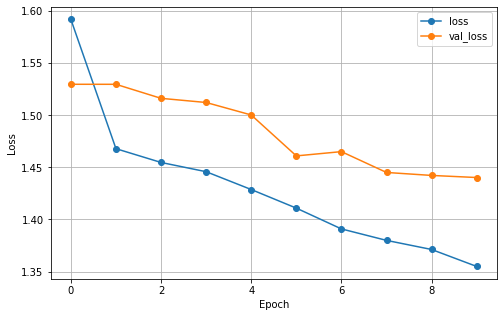

In [72]:
plt.plot(lstm_FT.history['loss'], label='loss', marker = 'o')
plt.plot(lstm_FT.history['val_loss'], label = 'val_loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='upper right')

Testing LSTM with FT 

In [73]:
lstmFT_pred = np.round(model.predict(X_test_final))

63/63 [==============================] - 1s 4ms/step


In [74]:
print('Accuracy %s' % accuracy_score(y_test, lstmFT_pred))
print('F1-score %s' % f1_score(y_test, lstmFT_pred, average=None))
print('Classification report:')
print(classification_report(y_test, lstmFT_pred, zero_division=1))

Accuracy 0.066
F1-score [0.         0.31168831 0.         0.         0.         0.
 0.         0.         0.         0.        ]
Classification report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       866
           1       0.80      0.19      0.31       683
           2       1.00      0.00      0.00       157
           3       1.00      0.00      0.00        95
           4       1.00      0.00      0.00        68
           5       1.00      0.00      0.00        62
           6       1.00      0.00      0.00        21
           7       1.00      0.00      0.00        15
           8       1.00      0.00      0.00        17
           9       1.00      0.00      0.00        16

   micro avg       0.80      0.07      0.12      2000
   macro avg       0.98      0.02      0.03      2000
weighted avg       0.93      0.07      0.11      2000
 samples avg       0.98      0.07      0.07      2000



#CNN classification with FastText

In [75]:
model = Sequential()

model.add(Embedding(max_features, embed_size, weights = [embedding_matrix], trainable =False))
model.add(Dropout(0.4))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())

#vanilla dense layer
model.add(Dense(hidden_dims, activation= 'relu'))
model.add(Dropout(0.4))
model.add(Activation('relu'))

#output layer
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 300)         6000000   
                                                                 
 dropout_6 (Dropout)         (None, None, 300)         0         
                                                                 
 conv1d_1 (Conv1D)           (None, None, 10)          9010      
                                                                 
 global_max_pooling1d_2 (Glo  (None, 10)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_6 (Dense)             (None, 10)                110       
                                                                 
 dropout_7 (Dropout)         (None, 10)                0         
                                                      

In [76]:
cnn_FT= model.fit(X_train_final, y_train, 
          batch_size = batch_size, 
          epochs=epochs, 
          shuffle=True, 
          validation_split=0.1,
          callbacks= [EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/20
113/113 [==============================] - 2s 9ms/step - loss: 1.8305 - accuracy: 0.3857 - val_loss: 1.5507 - val_accuracy: 0.4150
Epoch 2/20
113/113 [==============================] - 1s 5ms/step - loss: 1.6191 - accuracy: 0.4136 - val_loss: 1.4888 - val_accuracy: 0.4387
Epoch 3/20
113/113 [==============================] - 1s 5ms/step - loss: 1.5428 - accuracy: 0.4328 - val_loss: 1.4680 - val_accuracy: 0.4863
Epoch 4/20
113/113 [==============================] - 1s 5ms/step - loss: 1.5020 - accuracy: 0.4564 - val_loss: 1.4611 - val_accuracy: 0.4825
Epoch 5/20
113/113 [==============================] - 1s 5ms/step - loss: 1.4770 - accuracy: 0.4693 - val_loss: 1.4522 - val_accuracy: 0.4900
Epoch 6/20
113/113 [==============================] - 1s 5ms/step - loss: 1.4569 - accuracy: 0.4817 - val_loss: 1.4399 - val_accuracy: 0.4850
Epoch 7/20
113/113 [==============================] - 1s 5ms/step - loss: 1.4441 - accuracy: 0.4954 - val_loss: 1.4348 - val_accuracy: 0.4913
Epoch 

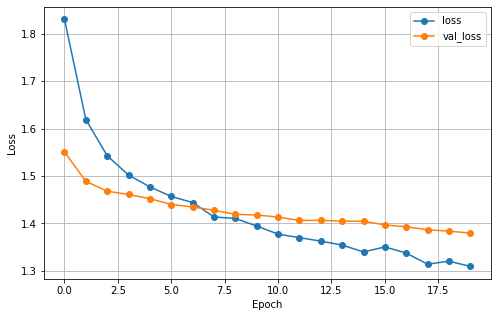

In [77]:
plt.plot(cnn_FT.history['loss'], label='loss', marker = 'o')
plt.plot(cnn_FT.history['val_loss'], label = 'val_loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='upper right')

Testing CNN with FastText

In [78]:
cnnFT_pred = np.round(model.predict(X_test_final))

63/63 [==============================] - 0s 5ms/step


In [79]:
print('Accuracy %s' % accuracy_score(y_test, cnnFT_pred))
print('F1-score %s' % f1_score(y_test, cnnFT_pred, average=None))
print('Classification report:')
print(classification_report(y_test, cnnFT_pred, zero_division=1))

Accuracy 0.3
F1-score [0.44381223 0.51705566 0.         0.         0.         0.
 0.         0.         0.         0.        ]
Classification report:
              precision    recall  f1-score   support

           0       0.58      0.36      0.44       866
           1       0.67      0.42      0.52       683
           2       1.00      0.00      0.00       157
           3       1.00      0.00      0.00        95
           4       1.00      0.00      0.00        68
           5       1.00      0.00      0.00        62
           6       1.00      0.00      0.00        21
           7       1.00      0.00      0.00        15
           8       1.00      0.00      0.00        17
           9       1.00      0.00      0.00        16

   micro avg       0.62      0.30      0.40      2000
   macro avg       0.92      0.08      0.10      2000
weighted avg       0.70      0.30      0.37      2000
 samples avg       0.81      0.30      0.30      2000



#Classification with Word2Vec

In [80]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [81]:
pip install --upgrade gensim


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.1 MB 77.9 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [82]:
import gensim
from gensim.models import Word2Vec

In [83]:
df_en['Genre_number'] = df_en['Genre'] #converting the strings into int in the Genre column

numbers = []
for i in df_en['Genre']:
  if i == 'Rock':
    numbers.append(0)
  
  if i == 'Pop':
    numbers.append(1)
   
  if i == 'Metal':
    numbers.append(2)
    
  if i == 'Jazz':
    numbers.append(3)

  if i == 'Folk':
   numbers.append(4)
  
  if i == 'Indie':
   numbers.append(5)

  if i == 'R&B':
    numbers.append(6)
  
  if i == 'Electronic':
    numbers.append(7)
  
  if i == 'Hip-Hop':
    numbers.append(8)

  elif i == 'Country':
    numbers.append(9)

In [84]:
df_en['Genre_number'] = numbers

In [85]:
#Gensim word2vec requires sentences in input so i split the lyrics into sentences
sentence_splitter = nltk.data.load('tokenizers/punkt/english.pickle')
sentences =[]
sum=0
for lyrics in df_en['Lyrics']:
  sents = sentence_splitter.tokenize(lyrics.strip())
  sum+=len(sents)
  for sent in sents:
    sentences.append(sent.split())
print(sum)
print(len(sentences))

10000
10000


In [86]:
#checking that the sentences are in the correct format
for sent in sentences[:5]:
  print(sent, "\n")

['face', 'down', 'with', 'the', 'la', 'curbside', 'endings', 'and', 'the', 'ones', 'in', 'zeros', 'downtown', 'was', 'the', 'perfect', 'place', 'to', 'hide', 'the', 'first', 'star', 'that', 'i', 'saw', 'last', 'night', 'was', 'a', 'headlight', 'of', 'a', 'man', 'made', 'sky', 'but', 'man', 'made', 'never', 'made', 'our', 'dreams', 'collide', 'collide', 'here', 'we', 'are', 'now', 'with', 'the', 'falling', 'sky', 'and', 'the', 'rain', 'we', 're', 'awakening', 'here', 'we', 'are', 'now', 'with', 'our', 'desperate', 'youth', 'and', 'the', 'pain', 'we', 're', 'awakening', 'maybe', 'it', 's', 'called', 'ambition', 'you', 've', 'been', 'talking', 'in', 'your', 'sleep', 'about', 'a', 'dream', 'we', 're', 'awakening', 'last', 'week', 'saw', 'me', 'living', 'for', 'nothing', 'but', 'deadlines', 'with', 'my', 'dead', 'beat', 'sky', 'but', 'this', 'town', 'doesn', 't', 'look', 'the', 'same', 'tonight', 'these', 'dreams', 'started', 'singing', 'to', 'me', 'out', 'of', 'nowhere', 'and', 'in', 'all'

In [87]:
#creating the w2v embeddings
w2v_model=gensim.models.Word2Vec(sentences=sentences, vector_size=300, window=10, min_count=1)

In [88]:
w2v_model.train(sentences, epochs=10, total_examples=len(sentences))

(18494115, 26083580)

In [89]:
#total num of extracted words
vocab = w2v_model.wv.index_to_key
print("Total number of words: ", len(vocab))

Total number of words:  36792


In [90]:
w2v_model.wv.most_similar('hello')

[('pos', 0.4648168087005615),
 ('luc', 0.4560096263885498),
 ('cooky', 0.434293270111084),
 ('robitaille', 0.41758114099502563),
 ('andrea', 0.4046867787837982),
 ('goodbye', 0.39015424251556396),
 ('samaritans', 0.3870192766189575),
 ('unknowns', 0.3826957643032074),
 ('contestant', 0.364735871553421),
 ('hi', 0.36184921860694885)]

In [91]:
#creating a dictionary with words in vocab and their embeddings. It will be used to create the embedding matrix 

word_vec_dict={}

for word in vocab:
  word_vec_dict[word]=w2v_model.wv.get_vector(word)

len(word_vec_dict)

36792

In [92]:
#finding the max length of the lyrics
maxi = -1
for i, lyrics in enumerate(df_en['Lyrics']):
  tokens=lyrics.split()
  if(len(tokens)>maxi):
    maxi=len(tokens)

print(maxi)

1924


In [93]:
#integer encoding the words in the lyrics using Keras Tokenizer
tok=Tokenizer()
tok.fit_on_texts(df_en['Lyrics'])
vocab_size = len(tok.word_index) +1
encoded_lyrics = tok.texts_to_sequences(df_en['Lyrics'])

In [94]:
max_lyrics_len=maxi
embed_dim = 300

#padding every sequence to the max length
padded_lyrics=pad_sequences(encoded_lyrics, maxlen=max_lyrics_len, padding='post')
padded_lyrics.shape

(10000, 1924)

In [95]:
#creating the embedding matrix
embed_matrix = np.zeros(shape=(vocab_size, embed_dim))
for word, i in tok.word_index.items():
  embed_vector=word_vec_dict.get(word)
  if embed_vector is not None: #if the word is in the vocabulary learned by the w2v model
    embed_matrix[i]=embed_vector
    #if the word is not found, the vector corresponding to the embedding will be filled with zeros

In [96]:
Y= to_categorical(df_en['Genre_number'], 10) #transforming the labels into one hot vectors
x_train,x_test,y_train,y_test=train_test_split(padded_lyrics, Y,test_size=0.20,random_state=42)

In [97]:
y_train.shape, y_test.shape

((8000, 10), (2000, 10))

#LSTM Classification with Word2Vec

In [98]:
from keras.initializers import Constant
epochs=5
batch_size=64


In [99]:
model=Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_lyrics_len, trainable = False, embeddings_initializer=Constant(embed_matrix)))
model.add(LSTM(12, dropout=0.4, recurrent_dropout=0.4))
model.add(Dropout(0.4))
model.add(Dense(24, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=SGD(learning_rate=0.01, momentum=0.8), metrics=['accuracy'])

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1924, 300)         11022000  
                                                                 
 lstm_2 (LSTM)               (None, 12)                15024     
                                                                 
 dropout_8 (Dropout)         (None, 12)                0         
                                                                 
 dense_8 (Dense)             (None, 24)                312       
                                                                 
 dropout_9 (Dropout)         (None, 24)                0         
                                                                 
 dense_9 (Dense)             (None, 10)                250       
                                                                 
Total params: 11,037,586
Trainable params: 15,586
Non-

In [100]:
lstm_w2v = model.fit(x_train,
                     y_train,
                     epochs=epochs,
                     batch_size=batch_size,
                     shuffle = True, 
                     validation_split=0.2, 
                     callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
lstm_w2v

Epoch 1/5
100/100 [==============================] - 322s 3s/step - loss: 1.9307 - accuracy: 0.4358 - val_loss: 1.6060 - val_accuracy: 0.4244
Epoch 2/5
100/100 [==============================] - 296s 3s/step - loss: 1.5275 - accuracy: 0.4263 - val_loss: 1.4919 - val_accuracy: 0.4244
Epoch 3/5
100/100 [==============================] - 292s 3s/step - loss: 1.4911 - accuracy: 0.4230 - val_loss: 1.4783 - val_accuracy: 0.4244
Epoch 4/5
100/100 [==============================] - 293s 3s/step - loss: 1.4774 - accuracy: 0.4234 - val_loss: 1.4741 - val_accuracy: 0.4244
Epoch 5/5
100/100 [==============================] - 290s 3s/step - loss: 1.4706 - accuracy: 0.4316 - val_loss: 1.4709 - val_accuracy: 0.4244


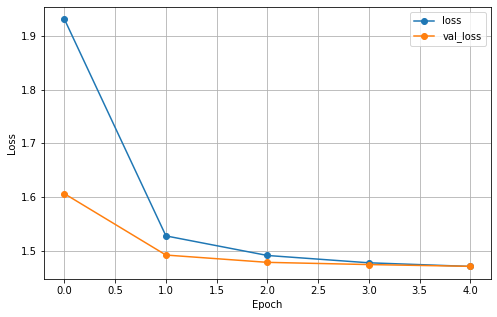

In [101]:
plt.plot(lstm_w2v.history['loss'], label='loss', marker = 'o')
plt.plot(lstm_w2v.history['val_loss'], label = 'val_loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='upper right')

Testing LSTM CLassification with w2v

In [102]:
lstmW2V_pred = np.round(model.predict(x_test))

63/63 [==============================] - 30s 475ms/step


In [103]:
print('Accuracy %s' % accuracy_score(y_test, lstmW2V_pred))
print('F1-score %s' % f1_score(y_test, lstmW2V_pred, average=None))
print('Classification report:')
print(classification_report(y_test, lstmW2V_pred))

Accuracy 0.0
F1-score [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       850
           1       0.00      0.00      0.00       725
           2       0.00      0.00      0.00       147
           3       0.00      0.00      0.00        91
           4       0.00      0.00      0.00        68
           5       0.00      0.00      0.00        62
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00        11
           8       0.00      0.00      0.00        16
           9       0.00      0.00      0.00        16

   micro avg       0.00      0.00      0.00      2000
   macro avg       0.00      0.00      0.00      2000
weighted avg       0.00      0.00      0.00      2000
 samples avg       0.00      0.00      0.00      2000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#CNN Classification with Word2Vec

In [104]:
filters=10
kernel_size=3
epochs=20

In [105]:
model=Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_lyrics_len, trainable=False, embeddings_initializer=Constant(embed_matrix)))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu', strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.4))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 1924, 300)         11022000  
                                                                 
 conv1d_2 (Conv1D)           (None, 1922, 10)          9010      
                                                                 
 global_max_pooling1d_3 (Glo  (None, 10)               0         
 balMaxPooling1D)                                                
                                                                 
 dropout_10 (Dropout)        (None, 10)                0         
                                                                 
 dense_10 (Dense)            (None, 32)                352       
                                                                 
 dropout_11 (Dropout)        (None, 32)                0         
                                                      

In [106]:
cnn_w2v = model.fit(x_train,
                     y_train,
                     epochs=epochs,
                     batch_size=batch_size,
                     shuffle = True, 
                     validation_split=0.2, 
                     callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/20
100/100 [==============================] - 2s 16ms/step - loss: 1.9343 - accuracy: 0.3486 - val_loss: 1.5056 - val_accuracy: 0.4231
Epoch 2/20
100/100 [==============================] - 2s 15ms/step - loss: 1.6126 - accuracy: 0.4081 - val_loss: 1.5135 - val_accuracy: 0.4631
Epoch 3/20
100/100 [==============================] - 2s 15ms/step - loss: 1.5394 - accuracy: 0.4236 - val_loss: 1.4852 - val_accuracy: 0.4769
Epoch 4/20
100/100 [==============================] - 2s 15ms/step - loss: 1.5029 - accuracy: 0.4311 - val_loss: 1.4926 - val_accuracy: 0.4975
Epoch 5/20
100/100 [==============================] - 1s 14ms/step - loss: 1.4803 - accuracy: 0.4487 - val_loss: 1.4690 - val_accuracy: 0.5088
Epoch 6/20
100/100 [==============================] - 2s 15ms/step - loss: 1.4666 - accuracy: 0.4597 - val_loss: 1.4481 - val_accuracy: 0.5163
Epoch 7/20
100/100 [==============================] - 2s 15ms/step - loss: 1.4515 - accuracy: 0.4720 - val_loss: 1.4333 - val_accuracy: 0.5206

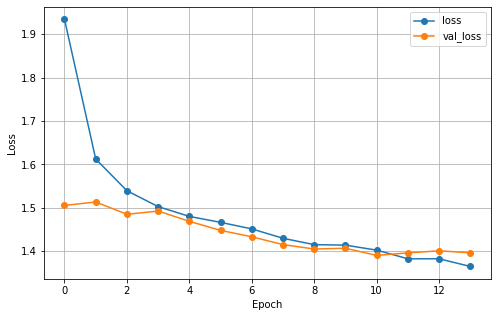

In [107]:
plt.plot(cnn_w2v.history['loss'], label='loss', marker = 'o')
plt.plot(cnn_w2v.history['val_loss'], label = 'val_loss', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc='upper right')

Testing CNN Classification with w2v

In [108]:
cnnW2V_pred = np.round(model.predict(x_test))

63/63 [==============================] - 0s 4ms/step


In [109]:
print('Accuracy %s' % accuracy_score(y_test, cnnW2V_pred))
print('F1-score %s' % f1_score(y_test, cnnW2V_pred, average=None))
print('Classification report:')
print(classification_report(y_test, cnnW2V_pred, zero_division=1))

Accuracy 0.124
F1-score [0.24015009 0.2764977  0.         0.         0.         0.
 0.         0.         0.         0.        ]
Classification report:
              precision    recall  f1-score   support

           0       0.59      0.15      0.24       850
           1       0.84      0.17      0.28       725
           2       1.00      0.00      0.00       147
           3       1.00      0.00      0.00        91
           4       1.00      0.00      0.00        68
           5       1.00      0.00      0.00        62
           6       1.00      0.00      0.00        14
           7       1.00      0.00      0.00        11
           8       1.00      0.00      0.00        16
           9       1.00      0.00      0.00        16

   micro avg       0.69      0.12      0.21      2000
   macro avg       0.94      0.03      0.05      2000
weighted avg       0.77      0.12      0.20      2000
 samples avg       0.94      0.12      0.12      2000

